In [1]:
from spacerocks import SpaceRock, Units
from spacerocks.spice import SpiceBody
from spacerocks.simulation import Simulation

from scipy.special import ellipk
from scipy.integrate import quad_vec
from numpy import sqrt
import numpy as np

import multiprocessing as mp

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as colors
%matplotlib inline


M_jupiter = SpiceBody('Jupiter Barycenter').mass.value
M_saturn  = SpiceBody('Saturn Barycenter').mass.value
M_uranus  = SpiceBody('Uranus Barycenter').mass.value
M_neptune = SpiceBody('Neptune Barycenter').mass.value

In [13]:
rock = SpaceRock.from_horizons('2015 BP519')

t0 = rock.epoch.tdb.jd
tf = t0 + 100_000_000 * 365.25
step = 365.25 * 10_000
epochs = np.arange(t0, tf, step)

In [14]:
a = rock.a.au[0]
H = np.sqrt(1 - rock.e**2) * np.cos(rock.inc.rad)
H = H[0]

In [15]:
sim = Simulation(model='GIANTS', epoch=t0)
sim.add_spacerocks(rock)

In [16]:
sim.integrator = 'mercurius'
sim.dt = 180

In [17]:
units = Units()
units.timescale = 'tdb'
prop, planets, sim = sim.propagate(epochs=epochs)

Output()

In [18]:
def integrand(aj, a, q, H, arg, M):

    e2 = (1 - q/a)**2
    inc = np.arccos(H / sqrt(1 - e2))
    rock = SpaceRock(a=np.repeat(a, len(arg)), 
                     q=np.repeat(q, len(arg)), 
                     inc=np.repeat(np.degrees(inc), len(arg)), 
                     arg=arg, 
                     node=np.zeros(len(arg)), 
                     M=np.repeat(M, len(arg)))

    x = rock.x.au
    y = rock.y.au
    xynorm = sqrt(x**2 + y**2)
    r = rock.r.au

    xi = 4 * aj * xynorm / (r**2 + aj**2 + 2 * aj * xynorm)

    return 4 * sqrt(1 - xi/2) * ellipk(xi) / sqrt(r**2 + aj**2)

def perturbation(a, q, H, arg):
    s = 0
    planet_ms = [M_jupiter, M_saturn, M_uranus, M_neptune]
    planet_as = [5.2, 9.6, 19.19, 30.1]
    
    for mj, aj in zip(planet_ms, planet_as):
        s += mj * quad_vec(lambda M: integrand(aj, a, q, H, arg, M), 0, 360)[0]
        
    return s

In [8]:
from joblib import Parallel, delayed, parallel_backend

In [9]:
Nq = 25
Nw = 25
qs = np.linspace(30, 40, Nq)
ws = np.linspace(0, 360, Nw)
W, Q = np.meshgrid(ws, qs)

In [10]:
with parallel_backend('threading', n_jobs=2):
    grid = Parallel()(delayed(perturbation)(a, q, H, ws) for q in qs)

grid = np.array(grid)

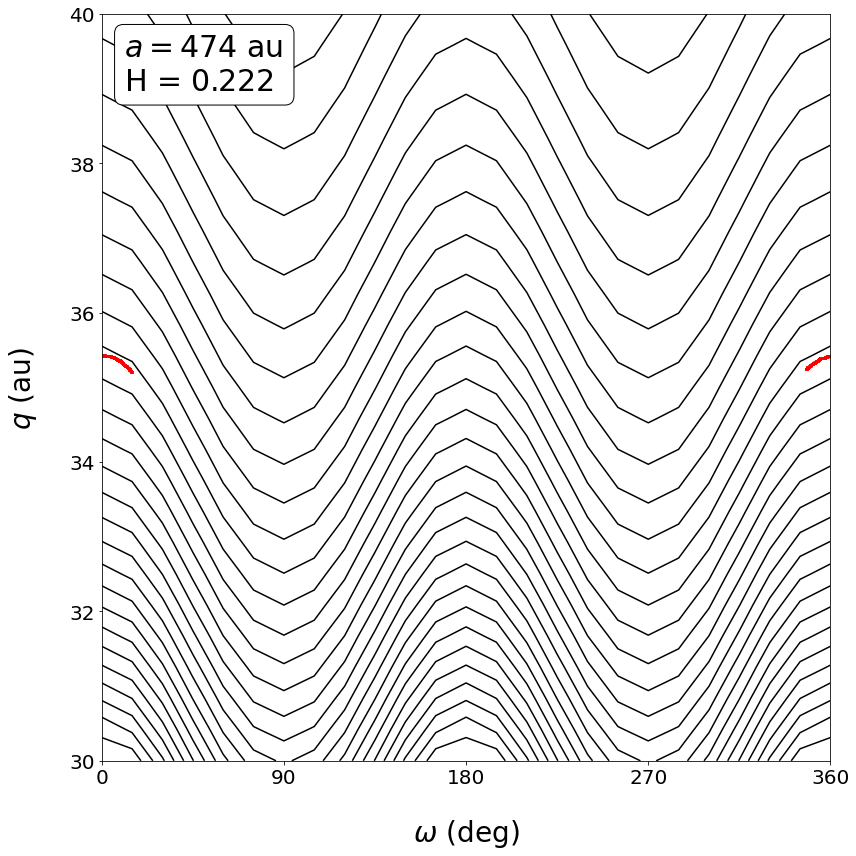

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))


ax.contour(grid, 
           extent=[0, 360, 30, 40],
           levels=30,
           #norm=norm,
           colors='black', 
           linestyles='-')

ax.scatter(prop.arg.deg, 
           prop.q.au, color='red', s=1)

ax.tick_params(labelsize=20)
ax.set_xlabel(r'$\omega$ (deg)', fontsize=28, labelpad=30)


ax.set_xticks([0, 90, 180, 270, 360])
ax.set_aspect('auto')

props = dict(boxstyle='round', facecolor='white', alpha=1)
textstr = '$a = {}$ au \nH = ${}$'.format(int(a), round(H, 3))
# place a text box in upper left in axes coords
ax.text(0.03, 0.89, textstr, transform=ax.transAxes, fontsize=30,
             verticalalignment='bottom', bbox=props)

ax.set_ylabel(r'$q$ (au)', fontsize=28, labelpad=30)
fig.tight_layout()
#fig.savefig('/home/kevin/Desktop/2015-BP519.pdf')